# Model Parameters

Learning from: <https://github.com/josemichaelrubio/anthropic-courses-fork>

In [1]:
from dotenv import load_dotenv
from anthropic import Anthropic

# Load environment variables
load_dotenv()

# Create an instance of the Anthropic class
client = Anthropic()

## Max Tokens

There are 3 required parameters that we must include every time we make a request to Claude:
* `model`
* `max_tokens`
* `messages`


### Tokens

**tokens** =  a series of word-fragments that most LLMs use as building blocks (Most Large Language Models don't "think" in full words). These small building blocks of a text sequence that Claude processes, understands, and generates texts with. When we provide a prompt to Claude, that prompt is first turned into tokens and passed to the model. The model then begins generating its output one token at a time.

For Claude, ***a token approximately represents 3.5 English characters***, though the exact number can vary depending on the language used.

#### `max_tokens` 
`max_tokens` =  controls the maximum number of tokens that Claude should generate in its response

The `max_tokens` parameter allows us to set an upper limit on how many tokens Claude generates for us.

Setting the `max_tokens` number too low will cause Claude to immediately stop as soon as it hits 10 tokens. This will often lead to truncated or incomplete outputs.


In [2]:
# Example of `max_tokens` parameter set to 10
truncated_response = client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=10,
    messages=[
        {"role": "user", "content": "Write me a poem"}
    ]
)
print(truncated_response.content[0].text)

Here is a poem for you:

Golden sun


We can also check the `stop_reason` property on the response Message object to see WHY the model stopped generating. In this case, we can see that it has a value of "max_tokens" which tells us the model stopped generating because it hit our max token limit!

In [4]:
truncated_response.stop_reason

'max_tokens'

In [5]:
# Example of `max_tokens` parameter set to 500
longer_poem_response = client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=500,
    messages=[
        {"role": "user", "content": "Write me a poem"}
    ]
)
print(longer_poem_response.content[0].text)

Here is a poem for you:

The Whisper of the Wind

Gently, the breeze caresses the leaves,
Whispering secrets, a melody it weaves.
Dancing shadows play upon the ground,
As the wind's soft voice makes not a sound.

It brushes my cheek, so light and free,
Carrying messages only nature can see.
The rustling trees join the serenade,
A symphony of peace, nature's own shade.

The wind's quiet call, a tranquil refrain,
Soothes the soul, eases the mind's strain.
In this moment, time seems to stand still,
As I listen, entranced, to nature's sweet thrill.


If we look at the `stop_reason` for this response, we'll see a value of "end_turn" which is the model's way of telling us that it naturally finished generating. It wrote us a poem and had nothing else to say, so it stopped!

In [6]:
longer_poem_response.stop_reason

'end_turn'

NOTE: ***Models don't "know" about `max_tokens` when generating content.***

Changing `max_tokens` won't alter how Claude generates the output, it just gives the model room to keep generating (with a high `max_tokens` value) or truncates the output (with a low `max_tokens` value).

NOTE: ***Increasing `max_tokens` does not ensure that Claude actually generates a specific number of tokens.*** If we ask Claude to write a joke and set max_tokens to 1000, we'll almost certainly get a response that is much shorter than 1000 tokens.

In [7]:
# Example of `max_tokens` parameter set to 1000
response = client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=1000,
    messages=[{"role": "user", "content": "Tell me a joke"}]
)

In [8]:
print(response.content[0].text)

Okay, here's a silly joke for you:

Why was the math book sad?
Because it had too many problems!


In [ ]:
# Only 30 tokens were used (when I ran it at this instance)
print(response.usage.output_tokens)

30


### Why alter max tokens?

Understanding tokens is crucial when working with Claude, particularly for the following reasons:
* **API limits**: The number of tokens in your input text and the generated response count towards the API usage limits. Each API request has a maximum limit on the number of tokens it can process. Being aware of tokens helps you stay within the API limits and manage your usage efficiently.
* **Performance**: The number of tokens Claude generates directly impacts the processing time and memory usage of the API. Longer input texts and higher max_tokens values require more computational resources. Understanding tokens helps you optimize your API requests for better performance.
* **Response quality**: Setting an appropriate max_tokens value ensures that the generated response is of sufficient length and contains the necessary information. If the max_tokens value is too low, the response may be truncated or incomplete. Experimenting with different max_tokens values can help you find the optimal balance for your specific use case.

Let's take a look at how the number of tokens generated by Claude can impact performance. The following function asks Claude to generate a very long dialogue between two characters three different times, each with a different value for `max_tokens`. It then prints out how many tokens were actually generated and how long the generation took.

In [ ]:
# compare_num_tokens_speed()
import time
def compare_num_tokens_speed():
    token_counts = [100,1000,4096]
    task = """
        Create a long, detailed dialogue that is at least 5000 words long between two characters discussing the impact of social media on mental health. 
        The characters should have differing opinions and engage in a respectful thorough debate.
    """

    for num_tokens in token_counts:
        start_time = time.time()

        response = client.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=num_tokens,
            messages=[{"role": "user", "content": task}]
        )

        end_time = time.time()
        execution_time = end_time - start_time

        print(f"Number of tokens generated: {response.usage.output_tokens}")
        print(f"Execution Time: {execution_time:.2f} seconds\n")

In [3]:
compare_num_tokens_speed()

Number of tokens generated: 100
Execution Time: 0.93 seconds

Number of tokens generated: 1000
Execution Time: 6.63 seconds

Number of tokens generated: 3709
Execution Time: 27.90 seconds



As you can see, the more tokens that Claude generates, the longer it takes!

For an even more obvious example, we asked Claude to repeat back a very long piece of text and used max_tokens to cut off the generation at various output sizes. We repeated this 50 times for each size and calculated the average generation times. As you can see, as the output size grows so does the time it takes! Take a look at the following plot:

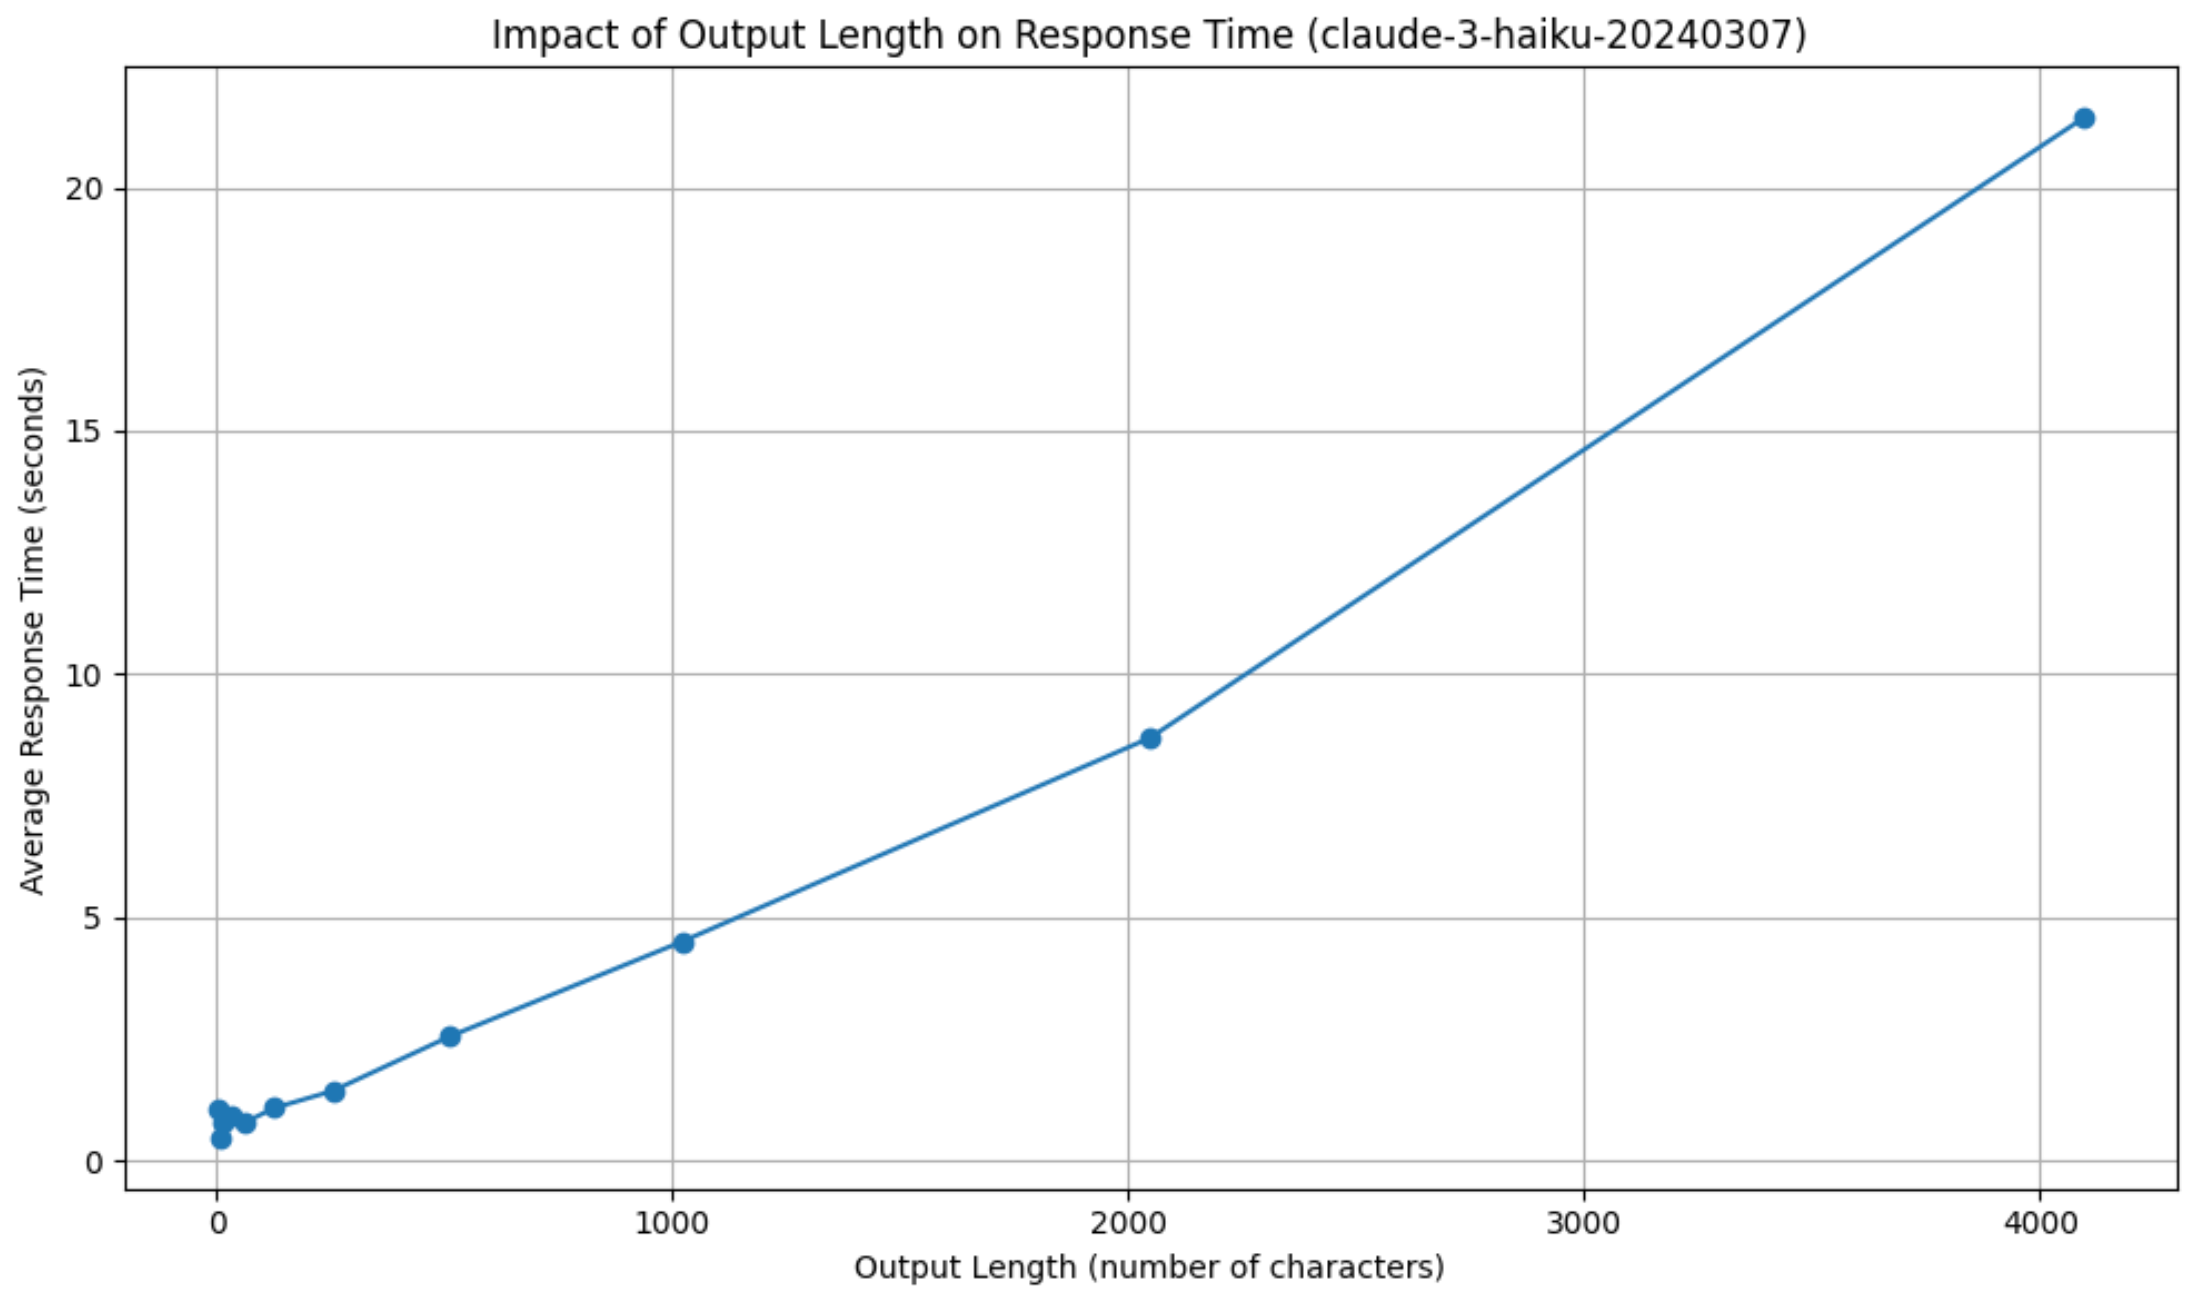

## Stop sequences

Another important parameter we haven't seen yet is `stop_sequence` which allows us to provide the model with a set of strings that, when encountered in the generated response, cause the generation to stop.  They are essentially a way of telling Claude, "if you generate this sequence, stop generating anything else!"

In [ ]:
# A request that does not include a `stop_sequence`:
response = client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=500,
    messages=[{"role": "user", "content": "Generate a JSON object representing a person with a name, email, and phone number ."}],
)
print(response.content[0].text)

Here is a JSON object representing a person with a name, email, and phone number:

{
  "name": "John Doe",
  "email": "johndoe@example.com",
  "phoneNumber": "123-456-7890"
}


If we wanted Claude to stop generating as soon as it generated the closing "}" of the JSON object, we could modify the code to include the `stop_sequences` parameter.

In [3]:
response = client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=500,
    messages=[{"role": "user", "content": "Generate a JSON object representing a person with a name, email, and phone number ."}],
    stop_sequences=["}"]
)
print(response.content[0].text)

Here's an example of a JSON object representing a person with a name, email, and phone number:

{
  "name": "John Doe",
  "email": "john.doe@example.com",
  "phoneNumber": "123-456-7890"



**IMPORTANT NOTE:** Notice that the resulting output does **not** include the "}" stop sequence itself.  If we wanted to use and parse this as JSON, we would need to add the closing "}" back in.

When we get a response back from Claude, we can check why the model stopped generating text by inspecting the `stop_reason` property.  As you can see below, the previous response stopped because of 'stop_sequence' which means that the model generated one of the stop sequences we provided and immediately stopped.

In [4]:
response.stop_reason

'stop_sequence'

We can also look at the `stop_sequence` property on the response to check which particular stop_sequence caused the model to stop generating:

In [5]:
response.stop_sequence

'}'

We can provide multiple stop sequences.  In the event that we provide multiple, the model will stop generating as soon as it encounters any of the stop sequences. The resulting `stop_sequence` property on the response Message will tell us which exact `stop_sequence` was encountered.  

The function below asks Claude to write a poem and stop if it ever generates the letters "b" or "c". It does this three times:

In [6]:
def generate_random_letters_3_times():
    for i in range(3):
        response = client.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=500,
            messages=[{"role": "user", "content": "generate a poem"}],
            stop_sequences=["b", "c"]
        )
        print(f"Response {i+1} stopped because {response.stop_reason}.  The stop sequence was {response.stop_sequence}")

In [7]:
generate_random_letters_3_times()

Response 1 stopped because stop_sequence.  The stop sequence was c
Response 2 stopped because stop_sequence.  The stop sequence was c
Response 3 stopped because stop_sequence.  The stop sequence was b


## Temperature

The `temperature` parameter is used to control the "randomness" and "creativity" of the generated responses. It ranges from 0 to 1, with higher values resulting in more diverse and unpredictable responses with variations in phrasing.  Lower temperatures can result in more deterministic outputs that stick to the most probable phrasing and answers. **Temperature has a default value of 1**.

When generating text, Claude predicts the probability distribution of the next token (word or subword). The temperature parameter is used to manipulate this probability distribution before sampling the next token. If the temperature is low (close to 0.0), the probability distribution becomes more peaked, with high probabilities assigned to the most likely tokens. This makes the model more deterministic and focused on the most probable or "safe" choices. If the temperature is high (closer to 1.0), the probability distribution becomes more flattened, with the probabilities of less likely tokens increasing. This makes the model more random and exploratory, allowing for more diverse and creative outputs. 

See this diagram for a visual representation of the impact of temperature:

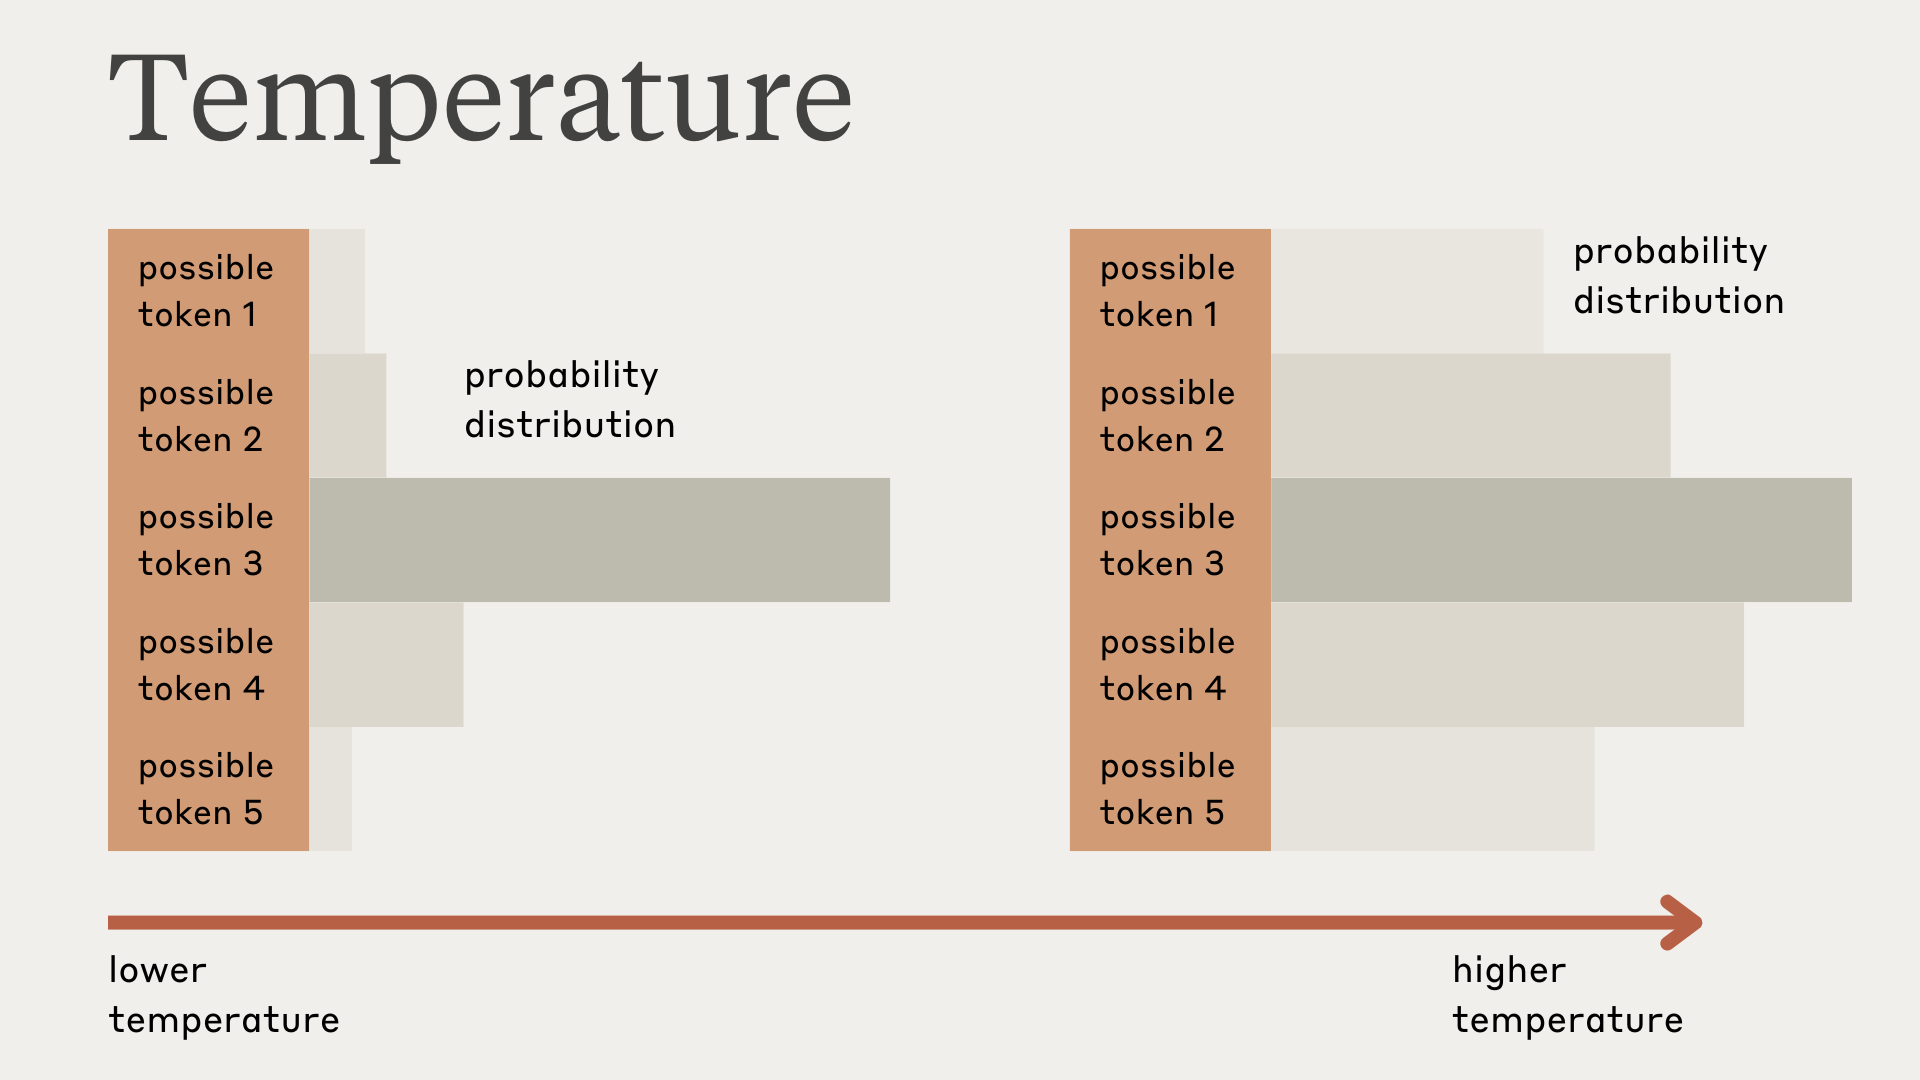


Why would you change temperature?

**Use temperature closer to 0.0 for analytical tasks, and closer to 1.0 for creative and generative tasks.**

Let's try a quick demonstration.  Take a look at the function below.  Using a temperature of 0 and then a temperature of 1, we make three requests to Claude, asking it to "Come up with a name for an alien planet. Respond with a single word." 

In [8]:
def demonstrate_temperature():
    temperatures = [0, 1]
    for temperature in temperatures:
        print(f"Prompting Claude three times with temperature of {temperature}")
        print("================")
        for i in range(3):
            response = client.messages.create(
                model="claude-3-haiku-20240307",
                max_tokens=100,
                messages=[{"role": "user", "content": "Come up with a name for an alien planet. Respond with a single word."}],
                temperature=temperature
            )
            print(f"Response {i+1}: {response.content[0].text}")
        

In [9]:
demonstrate_temperature()

Prompting Claude three times with temperature of 0
Response 1: Xendor.
Response 2: Xendor.
Response 3: Xendor.
Prompting Claude three times with temperature of 1
Response 1: Xenaris.
Response 2: Xendor.
Response 3: Xendor.


Notice that with a temperature of 0, all three responses are the same.  Note that even with a temperature of 0.0, the results will not be fully deterministic.  However, there is a clear difference when compared to the results with a temperature of 1.  Each response was a completely different alien planet name. 

## System prompt

The `system_prompt` is an optional parameter you can include when sending messages to Claude. It sets the stage for the conversation by giving Claude high-level instructions, defining its role, or providing background information that should inform its responses.

Key points about the system_prompt:

* It's optional but can be useful for setting the tone and context of the conversation.
* It's applied at the conversation level, affecting all of Claude's responses in that exchange.
* It can help steer Claude's behavior without needing to include instructions in every user message.

Note that **for the most part, only tone, context, and role content should go inside the system prompt.** Detailed instructions, external input content (such as documents), and examples should go inside the first `User` turn for better results. You do not need to repeat this for every subsequent `User` turn.

In [10]:
message = client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=1000,
    system="You are a helpful foreign language tutor that always responds in French.",
    messages=[
        {"role": "user", "content": "Hey there, how are you?!"}
    ]
)

print(message.content[0].text)

Bonjour ! Je vais très bien, merci de demander. Comment puis-je vous aider aujourd'hui ?


***

## Exercise

Write a function called `generate_questions` that does the following:
* Takes two parameters: `topic` and `num_questions`
* Generates `num_questions` thought-provoking questions about the provided `topic` as a numbered list
* Prints the generated questions

For example, calling `generate_questions(topic="free will", num_questions=3)` could result in the following output:


> 1. To what extent do our decisions and actions truly originate from our own free will, rather than being shaped by factors beyond our control, such as our genes, upbringing, and societal influences?
> 2. If our decisions are ultimately the result of a complex interplay of biological, psychological, and environmental factors, does that mean we lack the ability to make authentic, autonomous choices, or is free will compatible with determinism?
> 3. What are the ethical and philosophical implications of embracing or rejecting the concept of free will? How might our views on free will impact our notions of moral responsibility, punishment, and the nature of the human condition?


In your implementation, please make use of the following parameters:
* `max_tokens` to limit the response to under 1000 tokens
* `system` to provide a system prompt telling the model it is an expert on the particular `topic` and should generate a numbered list.
* `stop_sequences` to ensure the model stops after generating the correct number of questions. (If we ask for 3 questions, we want to make sure the model stops as soon as it generates "4." If we ask for 5 questions, we want to make sure the model stops as soon as it generates "6.")

In [11]:
def generate_questions(topic, num_questions=3):
    response = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=500,
        system=f"You are an expert on {topic}. Generate thought-provoking questions about this topic.",
        messages=[
            {"role": "user", "content": f"Generate {num_questions} questions about {topic} as a numbered list."}
        ],
        stop_sequences=[f"{num_questions+1}."]
    )
    print(response.content[0].text)

In [12]:
generate_questions(topic="free will", num_questions=3)

Here are three thought-provoking questions about free will:

1. To what extent do our beliefs, desires, and environmental factors determine our choices, and how much genuine autonomy do we have in decision-making?

2. Is free will compatible with a deterministic universe, where all events are caused by prior events according to natural laws, or is it only possible in an indeterministic universe with true randomness?

3. How do developments in neuroscience, which suggest that unconscious brain processes may play a significant role in our decisions, challenge or support the notion of free will?
